In [1]:

import numpy as np
import cleandata
import stockenv 
import sys
import pandas as pd
import warnings
import agentperform
import torch
import torch.nn as nn

from agents import DQN, DDQN

pwd = "C:/programming/MADDQN"
sys.path.append(pwd)

# Input Data Location, File Name, Stock name for labels
import_path = pwd + "/input_data"

# Output Path Location for CSV export
export_path = pwd + "/output_data"

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the current device
    device = torch.cuda.current_device()
    print(f"GPU Name: {torch.cuda.get_device_name(device)}")
else:
    device = 'cpu'
    print("CUDA (GPU support) is not available. PyTorch is running on CPU.")


stock_inputs ={'DJI':'^DJI_daily.csv',
               'NDAQ': '^IXIC_daily.csv',
               'SP500': '^SPX_daily.csv',
               'AAPL': 'AAPL_daily.csv',
               'AMZN': 'AMZN_daily.csv',
               'GOOGL': 'GOOGL_daily.csv',
               'MSFT': 'MSFT_daily.csv',
               'SINE': 'sine_wave_daily.csv'}

# Training Inputs
trn_keys = ['SINE']
training_range = (0,2500)
validation_range = (2500,2750)

ALPHA = 0.1
GAMMA = 0.9

# Testing Inputs
tst_keys = ['SINE']
testing_range = (2750,3000)

environments = {}

for name, file in stock_inputs.items():
    temp_df = cleandata.YAHOO_csv_input(file,import_path)
    temp_norm_df = cleandata.normalize_df_ohlcv_by_row_range(temp_df,training_range[0],training_range[1])
    environments[name] = stockenv.ContinuousOHLCVEnv(name,ohlcv_data=temp_norm_df.to_numpy(),
                                  stock_price_data=temp_df['close'].to_numpy(),
                                  commission_rate=0.005)


# Define a reward function outside the Environment class
def norm_6sig_1min(norm_num):
    """
    Function used to help division of normalized values (mean = 0).
    Input numbers close to zero outputs around 1, maintains input of -6:-2 to output 
    approx 6,2 (same for inputs 2:6). 6 standard deviations is approx 99.9999998%
    
    """
    result = np.exp(1.99*np.sin(0.59*(np.abs(norm_num) / np.pi)))
    if norm_num < -6.0 or norm_num > 6.0:
        warnings.warn(f'Input ({norm_num:.2f}) is outside of six standard deviations, output explodes exponentially')
    return result


def MADDQN_return_reward(env):
    n = 5 # How many days in the future
    
    
    current_price = env.stock_price_data[env.current_step]
    
    # Check if there are enough elements for the future prices
    if len(env.ohlcv_raw_data) < env.current_step + n:
        raise ValueError("Not enough OHLCV data for the future prices")
    
    tomorrows_price = env.stock_price_data[env.current_step+n]
    position = env.position
    reward = (((tomorrows_price - current_price)/current_price))*position
    opp_cost = 0.0002*(1-position) # Assuming risk-free return of 5% / 252 trading days + np.mean() in agents counts zeros
    
    return reward - opp_cost

 
def return_reward(env):
    n = 33 # How many days in the future
    
    
    current_price = norm_6sig_1min(env.ohlcv_raw_data[env.current_step,3])
    
    # Check if there are enough elements for the future prices
    if len(env.ohlcv_raw_data) < env.current_step + n:
        raise ValueError("Not enough OHLCV data for the future prices")
    
    tomorrows_price = norm_6sig_1min(env.ohlcv_raw_data[env.current_step:env.current_step+n,3].mean())
    position = env.position
    reward = (((tomorrows_price - current_price)/current_price))*position
    
    opp_cost = 0.0002*(1-position)*n # Assuming risk-free return of 5% / 252 trading days
    
    return 100*(reward - opp_cost)

def risk_reward(env):
    """
    Calculate the risk-reward ratio based on historical price data and current position in the environment.

    Args:
    - env: Environment object containing OHLCV raw data and position information.

    Returns:
    - float: Risk-reward ratio.
    """
    n = 33  # How many days in the future

    current_price = env.ohlcv_raw_data[env.current_step, 3]
    
    # Check if there are enough elements for the future prices
    if len(env.ohlcv_raw_data) < env.current_step + n:
        raise ValueError("Not enough OHLCV data for the future prices")
    
    tomorrows_price = env.ohlcv_raw_data[env.current_step:env.current_step+n, 3]
    position = env.position
    
    rewards = (tomorrows_price - current_price) / current_price
    
    rewards_mean = np.mean(rewards)  # Calculate mean using NumPy's mean function
    rewards_std = np.std(rewards)  # Calculate standard deviation using NumPy's std function
    
    
    
    return (rewards_mean / rewards_std) * position
   
    
    

def linear_decay(initial_epsilon, final_epsilon, current_epoch, total_epochs):
    if initial_epsilon == final_epsilon:
        return initial_epsilon
    elif total_epochs == 1:
        return final_epsilon
    else:
        rate_of_change = (final_epsilon - initial_epsilon) / (total_epochs-1)
        current_epsilon = np.round((initial_epsilon - rate_of_change) + (rate_of_change * current_epoch),3)
        
        if current_epsilon > initial_epsilon or current_epsilon < final_epsilon:
            raise ValueError(f'Epsilon value ({current_epsilon}) out of valid range ({initial_epsilon}:{final_epsilon})')
    
        return current_epsilon 


CUDA (GPU support) is not available. PyTorch is running on CPU.


c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\gymnasium\spaces\box.py:1

In [2]:
best_ddqn_agent = DDQN(name="MADDQN_sub_RTN",
                    environment=None,
                    reward_function=MADDQN_return_reward,
                    input_size= 6, 
                    hidden_size=256, 
                    output_size=3, 
                    activation_function = nn.GELU(),
                    num_hidden_layers = 2,                  
                    buffer_size=800, 
                    batch_size=140,
                    opt_lr= 0.0008,
                    alpha = ALPHA,
                    gamma = GAMMA,
                    opt_wgt_dcy = 0.0,
                    dropout_rate = 0.25,                    
                    device = device)




for key, env in environments.items():
  
        env.add_agent(best_ddqn_agent.get_name())
        env.set_decision_agent(best_ddqn_agent.get_name())



DJI ENV: Agent MADDQN_sub_RTN added
DJI ENV: Agent MADDQN_sub_RTN assigned as decision agent
NDAQ ENV: Agent MADDQN_sub_RTN added
NDAQ ENV: Agent MADDQN_sub_RTN assigned as decision agent
SP500 ENV: Agent MADDQN_sub_RTN added
SP500 ENV: Agent MADDQN_sub_RTN assigned as decision agent
AAPL ENV: Agent MADDQN_sub_RTN added
AAPL ENV: Agent MADDQN_sub_RTN assigned as decision agent
AMZN ENV: Agent MADDQN_sub_RTN added
AMZN ENV: Agent MADDQN_sub_RTN assigned as decision agent
GOOGL ENV: Agent MADDQN_sub_RTN added
GOOGL ENV: Agent MADDQN_sub_RTN assigned as decision agent
MSFT ENV: Agent MADDQN_sub_RTN added
MSFT ENV: Agent MADDQN_sub_RTN assigned as decision agent
SINE ENV: Agent MADDQN_sub_RTN added
SINE ENV: Agent MADDQN_sub_RTN assigned as decision agent


In [3]:
for key, env in environments.items():
    if key in trn_keys:
        
        best_ddqn_agent.set_environment(env)
        best_ddqn_agent.train(start_idx=training_range[0],
                    end_idx=training_range[1],
                    training_epsidoes= 30,
                    epsilon_decya_func= linear_decay,
                    initial_epsilon= 0.9,
                    final_epsilon= 0.1,
                    update_q_freq= 3,
                    update_tgt_freq= 20,
                    save_path = export_path,
                    val_start_idx = validation_range[0],
                    val_end_idx = validation_range[1],
                    early_stop = True,
                    stop_metric = 'val_avg_r',
                    stop_patience = 7,
                    stop_delta=0.0015)

        ddqn_trn = best_ddqn_agent.get_training_episodic_data()

        display(ddqn_trn)

MADDQN_sub_RTN: Training Initialized on SINE[0:2500] -> Validation on SINE[2500:2750]
MADDQN_sub_RTN: EP 10 of 10 Finished -> ΔQ1 = 0.03, ΔQ2 = 0.04 | ∑R = 566.01, μR = 0.23 σR = 0.42 | Min: val_std_r = 0.42 -> EarlyStopping counter: 3 out of 46 --> 0.000000).  Saving model ...
MADDQN_sub_RTN: Training finished on SINE[0:2500]


,trn_ep,tot_r,avg_r,std_r,Q1_loss,Q2_loss,epsilon,val_tot_r,val_avg_r,val_std_r,val_ror,val_comm_cost
0,1,195.281655,0.078113,0.420597,0.066770,0.044722,0.900,61.466188,0.245865,4.910403e-01,4.641486,3.711077e+04
1,2,229.398722,0.091759,0.420922,0.144964,0.147521,0.811,46.970033,0.187880,5.326092e-01,0.971124,7.657075e+04
2,3,272.095002,0.108838,0.432361,0.041284,0.022582,0.722,69.973959,0.279896,4.428908e-01,60.518313,2.048879e+05
3,4,311.013308,0.124405,0.433363,0.038635,0.031888,0.633,57.923238,0.231693,4.670181e-01,11.225824,1.696645e+05
4,5,372.842156,0.149137,0.435746,0.063143,0.057479,0.544,73.779502,0.295118,4.272773e-01,468.918464,1.011430e+06
5,6,357.070285,0.142828,0.424800,0.027088,0.029571,0.456,-0.050000,-0.000200,5.421011e-20,1.000000,0.000000e+00
6,7,425.445027,0.170178,0.434233,0.043329,0.058645,0.367,-0.050000,-0.000200,5.421011e-20,1.000000,0.000000e+00
7,8,465.705781,0.186282,0.417378,0.030243,0.025657,0.278,68.292702,0.273171,4.290684e-01,103.826347,2.778907e+05
8,9,487.850486,0.195140,0.417218,0.039247,0.052245,0.189,73.779502,0.295118,4.272773e-01,468.918464,1.011430e+06
9,10,566.014536,0.226406,0.420918,0.028405,0.037679,0.100,61.305709,0.245223,4.190147e-01,110.938853,2.589894e+05


MADDQN_sub_RTN: Testing Initialized on SINE[2750:3000]
MADDQN_sub_RTN - SINE[2750:3000] - Testing Finished - EPIDSODE - 1 of 1-> Total Reward = 59.26, Mean Reward = 0.24STD Reward = 0.41
MADDQN_sub_RTN: Testing Complete on SINE[2750:3000]


,Step,idx,Portfolio Value,Cash,Stock Value,Stock Holdings,Stock Price,Last Commission Cost,Total Commission Cost,State,Available Actions,Env Action,MADDQN_sub_RTN Action,MADDQN_sub_RTN Action Type,MADDQN_sub_RTN Q_Val Sell,MADDQN_sub_RTN Q_Val Hold,MADDQN_sub_RTN Q_Val Buy,MADDQN_sub_RTN Reward
0,1,2750,1.000000e+05,1.000000e+05,0.00,0,100.00,0.0000,0.0000,"[-0.00016675873010514947, -0.00016675873010514...","(H, B)",H,H,Best,1.767290,1.980660,1.280276,-0.000200
1,2,2751,1.000000e+05,1.000000e+05,0.00,0,114.74,0.0000,0.0000,"[0.41673006653327777, 0.41673006653327777, 0.4...","(H, B)",H,H,Best,1.426528,1.702901,0.981425,-0.000200
2,3,2752,1.000000e+05,1.000000e+05,0.00,0,128.17,0.0000,0.0000,"[0.7965756814102948, 0.7965756814102948, 0.796...","(H, B)",H,H,Best,0.870863,1.070016,0.580532,-0.000200
3,4,2753,1.000000e+05,1.000000e+05,0.00,0,139.09,0.0000,0.0000,"[1.1054300458523674, 1.1054300458523674, 1.105...","(H, B)",H,H,Best,0.526821,0.701603,0.331767,-0.000200
4,5,2754,1.000000e+05,1.000000e+05,0.00,0,146.54,0.0000,0.0000,"[1.3161411278206305, 1.3161411278206305, 1.316...","(H, B)",H,H,Best,0.370424,0.535599,0.223825,-0.000200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,2995,8.722688e+06,8.722688e+06,0.00,0,56.70,0.0000,215376.0336,"[-1.2248365371496768, -1.2248365371496768, -1....","(H, B)",B,B,Best,3.960327,4.528751,4.896526,0.266843
246,247,2996,8.766301e+06,4.362989e+04,7884248.75,153839,51.25,43613.3565,258989.3901,"[-1.3789808857036414, -1.3789808857036414, -1....","(S, H)",H,H,Best,4.339181,5.178164,3.725133,0.663610
247,248,2997,7.927879e+06,4.362989e+04,7713487.46,153839,50.14,0.0000,258989.3901,"[-1.4103754227485772, -1.4103754227485772, -1....","(S, H)",H,H,Best,4.454962,5.322814,3.862717,0.994416
248,249,2998,7.757117e+06,4.362989e+04,8224232.94,153839,53.46,0.0000,258989.3901,"[-1.316474645280841, -1.316474645280841, -1.31...","(S, H)",H,H,Best,4.098524,4.872259,3.440465,1.146278


c:\Users\beckm\anaconda3\envs\MADDQN\Lib\site-packages\quantstats\stats.py:349: RuntimeWarning: divide by zero encountered in scalar divide
  res = returns.mean() / downside


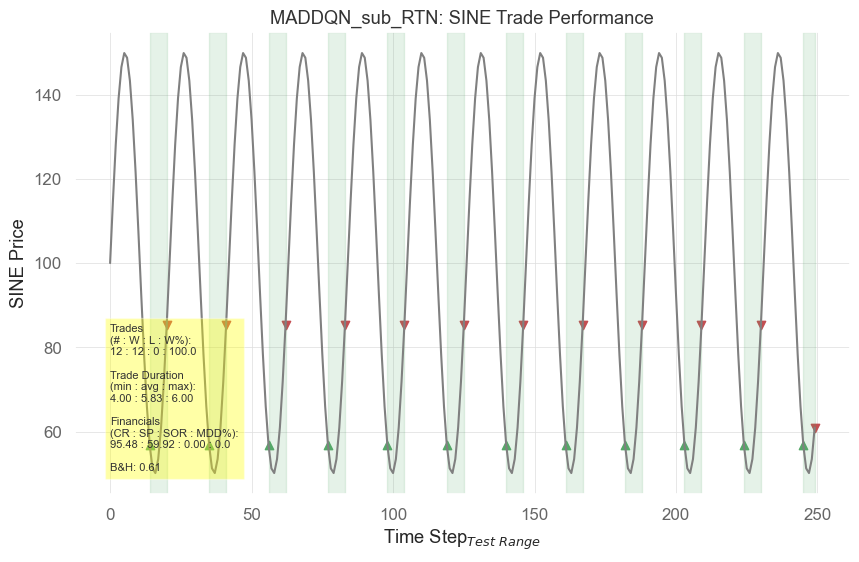

In [4]:
for key, env in environments.items():
    
    if key in tst_keys:

        best_ddqn_agent.set_environment(env)    
        best_ddqn_agent.test(start_idx = testing_range[0],
                       end_idx = testing_range[1], 
                       testing_epsidoes=1)

        a = env.get_step_data()
        b = best_ddqn_agent.get_step_data()
        combined_df = pd.concat([a,b],axis=1)
        display(combined_df)
        d = best_ddqn_agent.get_testing_episodic_data()
        agentperform.agent_stock_performance(env.stock_price_data[testing_range[0]:testing_range[1]],
                                            combined_df['Env Action'].to_numpy(),
                                            key,
                                            best_ddqn_agent.get_name(),
                                            display_graph=True,
                                            save_graphic=False,
                                            path_file=None)


In [5]:
environments['SINE'].csv_export_step_data("test_data.csv")

SINE: Step data exported to test_data.csv
